In [1]:
%run "../Functions/functions_v1.ipynb"

# Summary
In this notebook, we read in the cleaned data from 02_cleaned_data and we create 3 models described below

# Read in Data

In [3]:
df_stacked = pd.read_csv(f"../Data/cleaned_matches_stacked.csv")
df_stacked

,game_id,date,location,team,opp,score,opp_score,old_elo,opp_elo,elo_diff,result_class
0,2016-01-03IndiaAfghanistan,2016-01-03,South Asian Championship in India,India,Afghanistan,2,1,1063,1143,-80,T1
1,2016-01-03IndiaAfghanistan,2016-01-03,South Asian Championship in India,Afghanistan,India,1,2,1143,1063,80,T2
2,2016-01-06EstoniaSweden,2016-01-06,Friendly in the United Arab Emirates,Estonia,Sweden,1,1,1494,1767,-273,D
3,2016-01-06EstoniaSweden,2016-01-06,Friendly in the United Arab Emirates,Sweden,Estonia,1,1,1767,1494,273,D
4,2016-01-08BangladeshSri Lanka,2016-01-08,Bangabandhu Gold Cup in Bangladesh,Bangladesh,Sri Lanka,4,2,890,775,115,T1
...,...,...,...,...,...,...,...,...,...,...,...
16137,2024-07-13CanadaUruguay,2024-07-13,Copa América in the United States,Canada,Uruguay,2,2,1740,2003,-263,D
16138,2024-07-14ArgentinaColombia,2024-07-14,Copa América in the United States,Argentina,Colombia,1,0,2149,2070,79,T1
16139,2024-07-14ArgentinaColombia,2024-07-14,Copa América in the United States,Colombia,Argentina,0,1,2070,2149,-79,T2
16140,2024-07-14SpainEngland,2024-07-14,European Championship in Germany,Spain,England,2,1,2134,1997,137,T1


# Create Linear and Gradient Boosted Regressions
The goal of these two models will be to estimate the number of goals a team will score using the following variables:
* The team's ELO rating
* The opponent's ELO rating
* The ELO difference between the two
These models will then be used to forecast the number of goals two teams will score against each other. Then, we will run a poisson simulation to estimate the final score of X games, and calculate a teams win / draw / loss record based on those calculations

In [5]:
#here we create a train test split based on game id, so the model does not have the same game in training and validation 
splitter = GroupShuffleSplit(test_size=.2, n_splits=1, random_state = 4231)

split = splitter.split(df_stacked, groups=df_stacked['game_id'])
train_id, test_id = next(split)

train = df_stacked.iloc[train_id]
test = df_stacked.iloc[test_id]

In [6]:
#Currently model uses a teams elo, their opposition elo, and the elo difference 
x_train = train[["old_elo", "opp_elo", "elo_diff"]]
y_train = (train["score"])

x_test = test[[ "old_elo", "opp_elo", "elo_diff"]]
y_test = (test["score"])

In [7]:
#initialize and fit the models
gb = GradientBoostingRegressor(max_depth = 10, n_estimators = 1000, random_state=0).fit(x_train, y_train)
linreg = LinearRegression().fit(x_train, y_train)

In [8]:
#Get our validation set predictions
y_pred_gb = gb.predict(x_test)
y_pred_linreg = linreg.predict(x_test)

#Calculated RMSE
gb_rmse = math.sqrt(mean_squared_error(y_test, y_pred_gb))
linreg_rmse = math.sqrt(mean_squared_error(y_test, y_pred_linreg))

print(
f"""
Gradient Boosted Regression RMSE:{gb_rmse}
Linear Regression RMSE:{linreg_rmse}
""")


Gradient Boosted Regression RMSE:1.4635643095137976
Linear Regression RMSE:1.269011057351497




In [9]:
#save down models
joblib.dump(gb, '../Models/sklearn_gradient_boosted_model.pkl')
joblib.dump(linreg, '../Models/linreg_model.pkl')

['../Models/linreg_model.pkl']

# Create ELO Average Win Rate Model
* The goal of this model is to look at the historical win rate of a team given its elo difference vs its opponent.
* We will then use the historical win rate for each ELO difference as our forecast

In [11]:
#create  cross joined data frame of the all elo differences -1200 to -1200 in intervals of 50
#and for each class (T1, D, T2). Note: T1 is a team_1 win.

elo = []
result = []
for x in range(-1200, 1250, 50):
    for y in ["T1", "D", "T2"]:
        elo.append(x)
        result.append(y)

df_base = pd.DataFrame()
df_base["rounded_elo"] = elo
df_base["result_class"] = result
df_base

,rounded_elo,result_class
0,-1200,T1
1,-1200,D
2,-1200,T2
3,-1150,T1
4,-1150,D
...,...,...
142,1150,D
143,1150,T2
144,1200,T1
145,1200,D


In [12]:
df_stacked["rounded_elo"] = df_stacked["elo_diff"].apply(apply_elo_50_rounding)
df_stacked["count"] = 1

counts_by_elo = df_stacked.groupby(by = ["rounded_elo"])["count"].sum().reset_index()
counts_by_elo.columns = ["rounded_elo", "total_c"]
results_elo = df_stacked.groupby(by = ["rounded_elo", "result_class"])["count"].sum().reset_index()

joined = df_base.merge(results_elo, on = ["rounded_elo", "result_class"], how = "left").merge(counts_by_elo, on = ["rounded_elo"], how = "left").fillna(0)
joined["pct"] = joined["count"] / joined["total_c"]
joined["result_class"] = pd.Categorical(joined["result_class"], categories = ["T1", "D", "T2"], ordered = True)

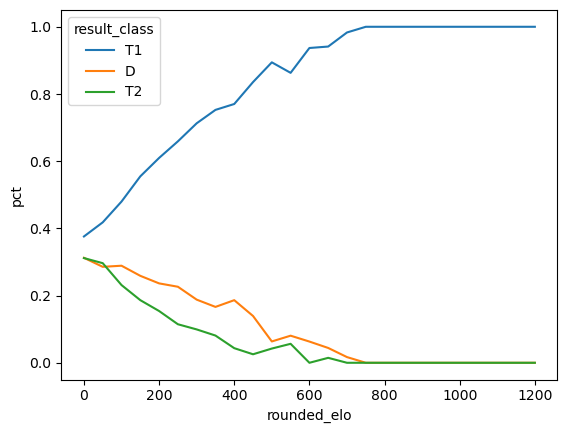

In [13]:
#Win rate for a given elo difference. Note this only shows the T1 / D / T2 (aka Win / Draw / Lose) for the higher rated team
sns.lineplot(data = joined[joined["rounded_elo"] >= 0]
             , x = "rounded_elo", y = "pct", hue = "result_class")
plt.show()

In [14]:
joined.to_csv('../Models/elo_win_rates.csv', index=False)